## Analyzing A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Project Overview

A/B tests are very commonly performed by data analysts and data scientists. Well-established products typically have a large consumer base and reliable sales and usage metrics, and are highly valued by their company. As a result, it's too risky to implement changes directly to the product without proper evaluation of the consequences.

To properly evaluate potential product changes, companies can use a technique called A/B testing. A/B testing is a randomized controlled experiment that uses a control (unchanged) and experimental (changed) group to test potential changes using a success metric. A/B testing is used to test whether or not the distribution of the success metric increases in the experiment group instead of the control group; we would not want to make changes to the product that would cause a decrease in the success metric.

It is important fully understand the concepts of A/B testing since they are widely used in the industry. This project focuses on best practices of A/B testing step by step.

For this project, I am analyzing an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
### Part I - Probability

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import random

# Vizuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

# Testing
random.seed(42)

`1.` a. Read in the `ab_data.csv` data & store it in `df`

In [2]:
df = pd.read_csv('Data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The umber of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# Proportion converted - this works for 0s and 1s
df.converted.mean()

0.11965919355605512

In [6]:
# # Proportion not converted - this works for 0s and 1s
# 1 - df.converted.mean()

In [7]:
# Another way to calculate (understanding formula "df.converted.mean()")
# Formula below is useful if column contain string or boolean value.
not_converted = df.query('converted == 0').user_id.count() #we could use nunique() insted of count
converted = df.query('converted == 1').user_id.count()   #we could use nunique() insted of count
proportion_converted = converted/df.shape[0]
not_converted, converted, proportion_converted

(259241, 35237, 0.11965919355605512)

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
# Treatment doesn't align with the new page
no_aligment1 = df.query('group == "treatment" and landing_page == "old_page"').count().timestamp #Not align
# New page doesn't align with the treatment
no_aligment2 = df.query('group == "control" and landing_page == "new_page"').count().timestamp #Not align
# Check how many times do align
aligment3 = df.query('group == "treatment" and landing_page == "new_page"').count().timestamp #Align

no_aligment = no_aligment1 + no_aligment2
no_aligment

3893

f. Missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` Clean up data (for the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page). Finding messy rows and removind the data from the dataset.

In [10]:
# Drop first condition
df_drop1 = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index)
# Drop second condition
df2 = df_drop1.drop(df_drop1[(df_drop1['group'] == 'control') & (df_drop1['landing_page'] == 'new_page')].index)

In [11]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` a. How many unique **user_id** values.

In [12]:
df2.user_id.nunique()

290584

b. Find the numner of duplicates and its values.

In [13]:
# How many duplicates in the dataset
df2.user_id.duplicated().sum()

1

In [14]:
# Display the duplicates (displays both duplicates)
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Information for the repeat **user_id**.

In [15]:
# Displays only one duplicate
# duplicate = df2[df2.user_id.duplicated(keep='first')]
# duplicate = df2[df2.user_id.duplicated(keep='last')]
duplicate = df2[df2.user_id.duplicated()]
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# Check shape before droping the row
df2.shape

(290585, 5)

d. Remove one of the duplicate.

In [17]:
# Drop the row by index
df2 = df2.drop([2893])

In [18]:
# Check if the drop is successful
df2.shape

(290584, 5)

`4.` a. The probability of an individual converting regardless of the page they receive?

In [19]:
converting_prob = df.converted.mean()
converting_prob

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
control_con_prob = df2.query('group == "control"').converted.mean()
control_con_prob

0.1203863045004612

In [21]:
# This is the calculation to understand formula above and/or in case the converted is a boolean or other non-numerical value.
control_con_prob2 = df2.query('group == "control" & converted == 1 ').user_id.nunique() / df2.query('group == "control"').user_id.nunique()
control_con_prob2

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
treat_con_prob = df2.query('group == "treatment"').converted.mean()
treat_con_prob

0.11880806551510564

d. The probability that an individual received the new page?

In [23]:
new_page_prob =  df2.query('landing_page == "new_page"').count().user_id / df2.shape[0]
new_page_prob

0.5000619442226688

e. ***Conclusion - Is there a sufficient evidence that the new treatment page leads to more conversions?*** 

>***Answer***<br>
*There is an equal chance to get either a new page or old page: P(old) = P(new) = 0.5 = 50%. The probability to convert given an old page or a new page is the same, that is 0.12 or 12% (this probability is calculated from the data we have). We can calculate Bayes Rule posterior probability and get the result for both 0.5 or 50% (P(CON|New_Page) = 0.06/0.012 = 0.5 & P(CON|Old_Page) = 0.06/0.012 = 0.5). Based on these calculations we cannot say that there is sufficient evidence that a new treatment page leads to more conversions.*

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For this analysis purposes I will make the decision just based on all the data provided.  I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

>***RESEARCH QUESTION: Does the experiment page drive higher traffic than the control page?***<br><br>
***$H_{0}$: The new version of a page draws the same amount or less traffic than the old version of a page (new version is equal or worse than the old).<br>
$H_{1}$: The new version of a page draws more traffic than the old version of a page (new version is better than the old version).***

$$H_0: p_{new} - p_{old} \le 0$$


$$H_1: p_{new} - p_{old} > 0$$

>*$p_{new}$ and $p_{old}$ are the values for the old page and the new page, respectively.*<br>

`2.` We assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

I will use a sample size for each page equal to the ones in **ab_data.csv** (no additional sample size needed, we are using the whole ab_data.csv dataset, as we would do in some cases)***<br>

I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>

a. The **convert rate** for $p_{new}$ under the null? 

In [24]:
p_new = df.converted.mean()
p_new

0.11965919355605512

b. The **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old = df.converted.mean()
p_old

0.11965919355605512

>***Note***<br>
*We assume that under the null hypothesis, p_new and p_old both have "true" success rates and therefore are equal to the converted success rate regardless of page - that is p_new and p_old are equal. Since they are both equal, we don't need to split into treatment types and consider all conversions together. Because we are using 0s and 1s to confirm conversion, it's possible to take the mean of this to find the rate (source: Udacity Knowledge FAQ).*


c. What is $n_{new}$?

In [26]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

>***Note***<br>
*Here we stimulate the sample with the np.random.binomial method*<br>
*WHY: We stimulate this under the null hypothesis, to see how the mean of distribution looks like if it came from the null hypothesis. Then we calculate p-value (from actual) in order to reject or fail to reject the null hypothesis.<br>
This is singular example for cell h where we stimulate for 10000 samples.<br><br>
1 = trial size (0s and 1s)<br>
p_new = probability of trial (calculated)<br>
n_new = number of trials to run<br>*

*because we are storing the value in form of 0s and 1s we use n=1: [np.random.binomial](https://stackoverflow.com/questions/27644617/difference-between-n-and-size-parameters-in-np-random-binomialn-p-size-1000)*

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
#This is the the stimulated mean difference under the null hypotesis.
p_diffs1 = new_page_converted.mean() - old_page_converted.mean()
p_diffs1

0.0017805434644503487

In [31]:
# This is the difference in acctual data (observed sample)
pdiff_actual = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
pdiff_actual

-0.0015782389853555567

>***Note***<br>
*Now that we know the observed difference in this sample (dataset in our case), we have to see if this difference is significant and not just due to chance. Therefore, we will simulate 10,000 values and calculate the differences in proportions ($p_{new}$ - $p_{old}$).*

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs = []
# No sample needed since we are using the whole dataset
# For loop is slower - using this computation to speed up the process much faster.
new_page_converted = np.random.binomial(n_new,𝑝_𝑛𝑒𝑤,10000)/n_new
old_page_converted = np.random.binomial(n_old,𝑝_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted 
p_diffs

array([ 4.81587551e-06, -4.28654702e-04,  1.27807885e-03, ...,
       -2.56915215e-03,  7.82620557e-04,  1.56031610e-03])

In [33]:
# Calculate the mean from the null
p_diffs_mean = p_diffs.mean()
p_diffs_mean

-5.266196384278568e-06

***Note: Formula explained***<br>
if: *np.random.binomial(n_new,𝑝_𝑛𝑒𝑤,10000)* -> we get results how many times 1s appear in one trial. <br>
if: *np.random.binomial(n_new,𝑝_𝑛𝑒𝑤,10000)/n_new* ->  we get a probabability of ocurrance of 1s.

n_new = trial size (0s and 1s)<br>
p_new = probability event of interest occurs on any one trial (calculated)<br>
10000 = number of times to run this experiment<br>

*because we are caunting how many times 1s appear in one trial we use n=n_new and divide with n/new to get the proportion: [np.random.binomial](https://stackoverflow.com/questions/27644617/difference-between-n-and-size-parameters-in-np-random-binomialn-p-size-1000)*

p_diffs = then we calculate the difference of probability converted between new and old page. It should be 0, since we are calculating this distribution form null hypotesis which is $H_0: p_{new} - p_{old} \le 0$

***Note: Further understanding of distribution and number of trialsFormula explained***<br>
*Below is a graphical visualization of distribution of a trials and the difference between 10000 trials and 50 trials.*
Source: [Stack Overflow](https://stackoverflow.com/questions/27644617/difference-between-n-and-size-parameters-in-np-random-binomialn-p-size-1000)*

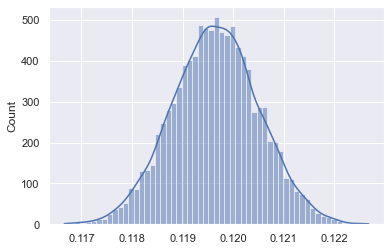

In [34]:
#new_page_converted = np.random.binomial(n_new,𝑝_𝑛𝑒𝑤,10000)/n_new
sns.histplot(new_page_converted, kde=True);

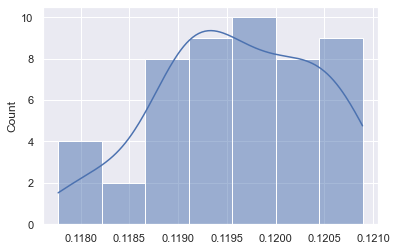

In [35]:
new_page_converted1 = np.random.binomial(n_new,𝑝_𝑛𝑒𝑤,50)/n_new
sns.histplot(new_page_converted1, kde=True);

>***Note***<br>
*When conducting hypothesis testing, we always simulate the null population and then compare to the observed statistic.*

i. Plot a histogram of the **p_diffs**.  
>***Note***<br>
*This plot is expected - follow normal distribution (large number and normal distribution theory). Above are two plots that show what happen if the number of trials is low in comarisson with a large number of trials.*

In [36]:
# view 95% confidence interval
low, upper = np.percentile(p_diffs, .05), np.percentile(p_diffs, 99.5)

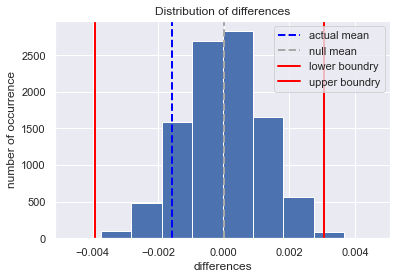

In [37]:
plt.hist(p_diffs); #plot the distribution of 10,000 samples under null hypotesis
plt.axvline(pdiff_actual , color='blue', linewidth=2, linestyle='dashed', label='actual mean'); #plot the accutual observation
plt.axvline(p_diffs_mean, color='darkgray', linewidth=2, linestyle='dashed', label='null mean'); #plot the mean from the null
plt.axvline(low,  color='red', linewidth=2, label='lower boundry'); # lower boundry of 95% confidence interval
plt.axvline(upper,  color='red', linewidth=2, label='upper boundry'); # upper boundry of 95% confidence interval
plt.title('Distribution of differences');
plt.xlabel('differences');
plt.ylabel('number of occurrence')
plt.legend();

# Save the figure.
#plt.savefig("Visuals/Distribution_of_differences.png")

>**blue area**: the distribution from the null (assuming the null is true)<br>
**dark blue dashed line**: the observed mean - actual mean (not from the null)<br>
**gray dashed line**: the null mean<br>
**red lines**: 95% confidence interval<br><br>
Now we need to calculate the area - our alternative hypothesis is: $H_1: p_{new} - p_{old} > 0$

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [38]:
# p_diffs > pdiff_actual
p_diffs = np.array(p_diffs)
null_value = np.random.normal(0, p_diffs.std(), p_diffs.size)

# Compute p-value
p_value = (null_value > pdiff_actual).mean()
p_value

0.9033

k. Explaination of the computations above.

>**Answer**<br>
Firstly we made 10,000 trials assuming p_old and p_new are equal (they are coming from a null hypothesis) and created a normal distribution of differences under this assumption. Next, we compared this distribution with the actual difference in our dataset to see how likely our null hypothesis is - this is a p-value. We use p-value to determine the statistical significance of our observed difference. <br>

>In cell j we computed p-value for our statistics which is the observed difference in proportions.<br>
Firstly, we calculated by simulating the distribution under the null hypothesis and then finding the probability that our statistics came from this distribution. To simulate from the null we created a normal distribution centered at zero with the same standard deviation as sampling distribution and size. Next, we computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.<br>

>***Formula explained:***<br>
*np.random.normal -> Draw random samples from a normal (Gaussian) distribution<br>
loc = 0 -> Mean (“centre”) of the distribution (p_diffs = 0)<br>
scale = p_diffs.std() -> Standard deviation (spread or “width”) of the distribution<br>
size = p_diffs.size -> Size of distribution.<br>*

>***p-value of 0.9009 means that nearly all statistics came from a null (almost all ~ 90%); therefore, we fail to reject null hypothesis, meaning that alternative hypothesis is not true (new page is the same or worse than the old page.)***

>**Note and additional resources**<br>
The p-value helps us make a decision. Because of the way we construct our assumptions, when calculated, the p-value tells us the probability of committing a Type I error if the null hypothesis is true. (A Type I error is when you incorrectly reject the null hypothesis - usually we would consider making Type I errors to be 'bad,' so we want to make as few of them as possible, and make this chance quite low)<br>
A low p-value is often considered to be less than 0.05 in business and research, and 0.01 in medicine, but it could be any value appropriate to the situation. That is, if you get a p-value that is 0.05, this means that there is a 5% chance that a statistic that you observed came from a population where the null hypothesis is true. With this reasoning, at low p-values we typically reject the null hypothesis. That is, we act on the assumption that the observed statistic came from a population where the alternate hypothesis is true.
Source: [p-value](https://rebeccaebarnes.github.io/2018/05/01/what-is-a-p-value)


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Below are calculations for neccessary parameters for stats.proportions_ztest. The number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [39]:
convert_old = df2.query('group == "control" & converted == 1').user_id.count()
convert_new = df2.query('group == "treatment" & converted == 1').user_id.count()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Usin `stats.proportions_ztest` to compute test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest) is a helpful link on using the built in.

In [40]:
import statsmodels.api as sm
z_test, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_test, p_value

(-1.3109241984234394, 0.9050583127590245)

In [41]:
# In order to correctly interpret z-score we need to calculate critical value 
# import library
from scipy.stats import norm
# Determine our critical value (upper bound is 95%)
p = 0.95
# Calculate
cval = norm.ppf(p)
cval

1.6448536269514722

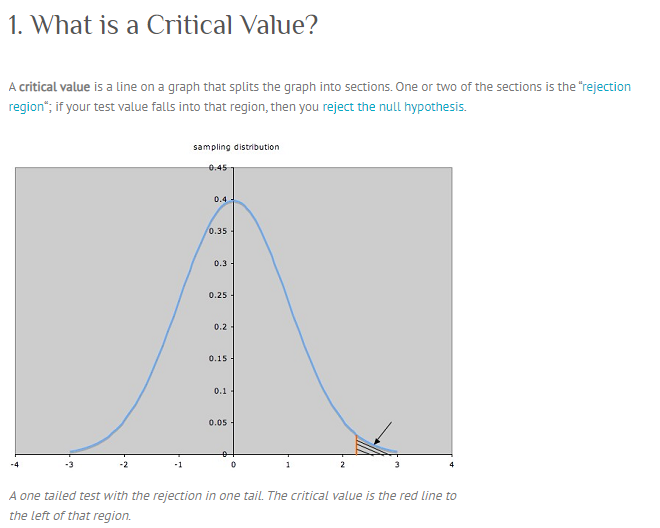

In [42]:
from IPython import display
display.Image("Resources/criticalvalue.png", width=500)

*Source: [statisticshowto.com](https://www.statisticshowto.com/probability-and-statistics/find-critical-values/)*

n. Explanation of z-score and p-value and comparisson with Part I.

>**Answer**<br>
Proportions z_test build-in function did all the computation in a few lines of code that reflect what we did in Part II. P-value is the same as in Part II (in cell j).
p-value and z-score computed in cell m agree with p-value computed in cell j, that is p-value of 0.905, meaning we fail to reject the null hypothesis and based on this computations we can conclude that the new page won't attract more traffic.

>**Interpretation of p-value and z-value**<br>
The **z-value** is a test that measures the difference between an observed statistic and its hypothesized population parameter in units of standard error. We can compare the z-value to critical values of the standard normal distribution to determine whether to reject the null hypothesis. z-score shows how many standard deviations away our observed (actual) difference is to the center. How many standard deviations away pdiff_actual is from p_diffs. In order to interpret z-score we look at the critical value. Critical value for the 95% confidence interval (or alpha level of 0.05 or 5%) is 1.64. Our z-test is -3.11; therefore z-score value falls out of this critical value and we fail to reject the null hypothesis.<br><br>
The **p-value** is a probability that measures the evidence against the null hypothesis. A smaller p-value provides stronger evidence against the null hypothesis.


Source: [minitab.com](https://support.minitab.com/en-us/minitab/19/help-and-how-to/statistics/basic-statistics/how-to/1-sample-z/interpret-the-results/all-statistics-and-graphs/)

***Graphical display of z-test, standard deviations and critical value***

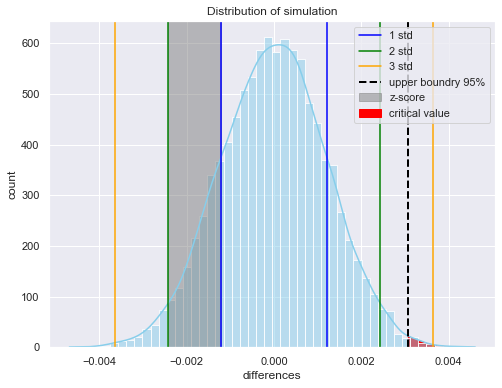

In [43]:
# calculating standard deviations
standart_deviation = np.std(p_diffs)
std1_low = 0 - standart_deviation*1
std1_high = 0 + standart_deviation*1
std2_low = 0 - standart_deviation*2
std2_high = 0 + standart_deviation*2
std3_low = 0 - standart_deviation*3
std3_high = 0 + standart_deviation*3

# visualizing
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(p_diffs, bins=50, color="skyblue", kde=True);
plt.axvline(x=std1_low, color='blue', label='1 std');
plt.axvline(x=std1_high, color='blue');
plt.axvline(x=std2_low, color='green', label='2 std');
plt.axvline(x=std2_high, color='green');
plt.axvline(x=std3_low, color='orange', label='3 std');
plt.axvline(x=std3_high, color='orange');
plt.axvline(upper,  color='black', linewidth=2, linestyle='dashed',label='upper boundry 95%'); # upper boundry of 95% confidence interval
plt.title('Distribution of simulation');
plt.xlabel('differences');
plt.ylabel('count')

# Shade the are between the curve and alpha - where critical value is
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x>upper), 
                interpolate=True, alpha=1, color='red', label='critical value')

# Shade the area between std-1 and std -2 where z-score is:
ax.axvspan(std1_low, std2_low, alpha=0.5, color='gray', label='z-score')

# This will shade all area from "upper" til the end of the chart - not used in this chart, but kept for the reference.
#ax.axvspan(upper, xlim[1], alpha=0.3, color='red', label='critical value')
# Get x-axis limit to shade the area
#xlim = ax.get_xlim()
#ax.margins(x=0)

plt.legend();

# Save the figure.
#plt.savefig("Visuals/Distribution_of_simulation.png")

*z-score of -1.31 falls between -1st and -2nd standard deviation - shaded gray area<br>
critical value of $\alpha$ = 0.05 (95% confidence interval) - shaded red area*


***Source: Udacity Knowledge FAQ & [z-score](https://www.statisticshowto.com/probability-and-statistics/z-score/) & [stacloverflow](https://stackoverflow.com/questions/46685453/how-to-fill-with-a-different-color-an-area-in-seaborn-distplot)***

<a id='regression'></a>
### Part III - A regression approach

`1.` Previous results in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, I will use logistic regression.

>**Answer** <br>
Unlike linear regression (used for predicting quantiative response a continious numerical variable), logistic regression is used to predict a categorical response, a binary response with only two possible outcomes in our case a conversion vs. no conversion.

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  First we need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [44]:
import statsmodels.api as sm
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['landing_page'])['new_page']

>***Note***<br>
*Intercept == 1: initialize the value of the bias to 1 because it will be multiplied by the bias weights to produce the final bias value. If it was set to 0, it would always produce 0. If it was set to 5 it would scale the weights to much.<br> Source: Udacity Knowledge.*

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [46]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 May 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:48:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [48]:
# Exponentiate each variable. Now each of these resulting value is the multiplicative change in the odds
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [49]:
# Calculate the reciprocal -  with the values less than 1.
1/_

intercept    7.306593
ab_page      1.015102
dtype: float64

e. Compute the p-value associated with **ab_page**.<br><br> **Observation** p-value differ from the value in **Part II**.<br>**Question**: What are the null and alternative hypotheses associated with regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

>**Answer** <br> p-value for ab_page is 0.190. This p-value still indicates the same as p-value in Part II, that is we fail to reject the null hypotesis and based on this computations we can conclude that the new page won't attrack more traffic.
The p-value differs because in Part II, we are doing a one-sided test since our null hypothesis is "p_old - p_new >= 0" in Part III, we are doing a two-sided test ("p_old = p_new"). For logistic regression we have two outputs possible "converted" or "not converted."

f. Additionaly we are considering other things that might influence whether or not an individual converts.  Sometimes it is a good idea to consider other factors to add into regression model.

>**Answer** <br>
Adding other features to the model can improve the model performance; however, we need to be carful with the interpretation. One potential side effect of having multicollinearity in the model is that the coeficent can be counter-intuitive. This happen if predictors are strongly corelated with one another. We can check for this correlation either with scatter plots or VIFs (variance inflation factors). In order to interpret the model more accurately we could remove at least one of highly correlated variable that are of least interest.

g. Adding an effect based on which country a user lives along with testing and testing if the conversion rate changes for different pages.

**Question:** Does it appear that country had an impact on conversion?

In [50]:
countries_df = pd.read_csv('Data/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0


In [51]:
# Country dummies - check what values we have
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [52]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,1,0,0
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0,0,1,0


In [53]:
# drop one column to get full rank
df_new = df_new.drop('US', axis=1)

In [54]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 May 2021   Pseudo R-squ.:               1.521e-05
Time:                        15:49:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

>***Interpretation of the results - p-value***<br>
Based on the p-value country doesn't have impact on conversion. None of the variables are statistical significant (p-value < 0.05). In logistic regression model summary we might use p-values to help us understand if a particular variable was significant and it's a great quick check to understand which relationship appear to be important. Furthermore we can interpret these coeficients to help us understand corelations.

>***In order to interpret coeficient we need to exponentiate each:***<br>
*The math.exp() method returns E raised to the power of x (Ex).
'E' is the base of the natural system of logarithms (approximately 2.718282) and x is the number passed to it.*
[www.w3schools](https://www.w3schools.com/python/ref_math_exp.asp)

In [55]:
# Exponentiate each variable. Now each of these resulting value is the multiplicative change in the odds
np.exp(results.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

In [56]:
# Calculate the reciprocal -  with the values less than 1.
1/_

intercept    7.364925
CA           1.041647
UK           0.990133
dtype: float64

>***Interpretation of the results - coeficient***<br>
> This results in multiplicative change in the odds of being in the one category of this value, holding all other variable constant.<br>
We can interpret results above if individual is from US is 1.01-times likely to convert than if they came form UK and individual is 1.04 likely to convert if they came form CA.


In [57]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 05 May 2021   Pseudo R-squ.:               2.323e-05
Time:                        15:49:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [58]:
# Exponentiate each variable. Now each of these resulting value is the multiplicative change in the odds
np.exp(results2.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [59]:
# Calculate the reciprocal -  with the values less than 1.
1/_

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

***Interpretation of the results***<br>
Adding more terms in this case did not change the model.  None of the variables are statistical significant (p-value < 0.05) and coeficient stayed similar than in model above. 
We can conclude that there is no significant p-value(all higher than 0.05) even after the addition of country dependent conversion and therefore we fail to reject the null. Company should stay on the old_pages only as there's no enough evidence that the new_pages are doing better.

h. In addition to the individual factors of country and page on conversion, we can look at an interaction between page and country to see if there significant effects on conversion.

In [60]:
# adding interaction between page and country
df_new['CA_abpage'] = df_new.CA*df_new.ab_page
df_new['UK_abpage'] = df_new.UK*df_new.ab_page

*When we include higher order terms into our model we also need to include lower order terms. Mathematically, an interaction is created by multiplying two variables by one another and adding this term to our linear regression model. If the slope (vertical difference) between two variables is not the same, we consider adding interaction in our model if the slope is the same than we do not add an interaction.*

In [61]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
log_mod_int = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK','ab_page', 'CA_abpage', 'UK_abpage']])
results_int = log_mod_int.fit()
results_int.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 05 May 2021   Pseudo R-squ.:               3.482e-05
Time:                        15:49:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA_abpage     -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_abpage      0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

***Interpretation of results***
When the slopes for two variables no longer match we would want to add an interaction term between two variables (page and country) to our model. In this case the way ab page is related to the converted and is dependent from which country that individual is coming from.

Adding higher terms did not improve the model. Based on p-value for CA_abpage and UK_abpage is 0.383 and 0.238, respectively indicating that interactions are not significant and we would consider removing them from the model. 
However it is essential to be aware of interactions since they can improve our models or even hurt if we do not add them and show significance. 


***Higher order terms - notes***<br>
Sometimes we would like to fit models where the response is not lineary related to the explanatory variable. We can do this with what are known as higher order terms. Higher order terms include quadratics, cubics and many other relationships. In order to add these terms to our linear models, we can simply multiply our columns by one another. 

<a id='conclusions'></a>
## Conclusions

p-value of 0.9009 means that nearly all statistics came from a null (almost all ~ 90%); therefore, we fail to reject null hypothesis, meaning that alternative hypothesis is not true and we can conclude that new page won't drive more traffic so company should stay with the old page. Z-score idicate similar: Critical value for the 95% confidence interval (or alpha level of 0.05 or 5%) is 1.64. Our z-test is -3.11; therefore z-score value falls out of this critical value and we fail to reject the null hypothesis.
Adding additional features did not improve our model, since none of the features indicated significance. However it is essential to check for higher order interactions in order not to miss anything. The bottom line is we fail to reject null hypothesis and the company should stick with the old page.

**Room for further research:<br>**
However, the analysis could not stop here. The hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another? These questions are the difficult parts associated with A/B tests in general.

***Additional notes - not part of the analysis***<br>
🎈logistic regression: confusion matrix, exponentiate each variable, VIF & multicollinearity<br>
🎈 multiple linerar regression: VIF, scatter plots in multicollinearity<br> [VIF&multicollinearity](Multicollinearity_And_VIFs_forReference.ipynb)



🎈 (from A/B testing)Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed. 
However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  
These questions are the difficult parts associated with A/B tests in general.  